In [1]:
import math
import os as os
from itertools import combinations
from pathlib import Path
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import rpy2.robjects as ro
import seaborn as sns

from jax import random
from jax import jit

#import optax
from numba import njit
import numba as nb
from numpy import genfromtxt

jax.default_backend()

Error importing in API mode: ImportError("dlopen(/Users/xiaohengzhu/miniconda3/envs/phylo/lib/python3.10/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <8E810785-E2C5-379D-B86B-D84709B6C758> /Users/xiaohengzhu/miniconda3/envs/phylo/lib/python3.10/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.
/Users/xiaohengzhu/miniconda3/envs/phylo/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/"

'cpu'

In [2]:
# parameters
rooted = True

Analytical Gradient without checkpoint

In [3]:
@njit(fastmath=True)
def forward(W):
    n_leaves = len(W) + 1
    E = np.zeros((n_leaves, n_leaves), dtype=W.dtype)
    E_new = np.zeros((n_leaves, n_leaves), dtype=W.dtype)
    cache = np.zeros((n_leaves-1,n_leaves, n_leaves), dtype=W.dtype)
    for i in range(1, n_leaves):
        E_before_sub = E[:i, :i]
        E_new.fill(0) 
        w_row_sub = W[i-1,:i]
        for k in range(i):
            for j in range(k):
                E_new[k, j] = E_before_sub[k, j] * (1 - 0.5 * (w_row_sub[j] + w_row_sub[k]))
            E_new[i, k] = 0.5 * np.sum(E_before_sub[:i, k] * w_row_sub) + 0.25 * w_row_sub[k]
        E = E_new + E_new.T
        cache[i-1,:i,:i] = E_before_sub

    return E, cache

In [4]:

@njit(fastmath=True)
def backward(W, D, cache):
    dW = np.zeros_like(W)
    dE = D.copy()
    for j in range(cache.shape[0]-1, -1, -1):
        i = j + 1
        w_row_sub = W[i-1,:i]
        E_before_sub = cache[j,:i,:i]
        i_idx = i - 1
        dE_new = dE + dE.T

        dE_before_accum_sub = np.zeros_like(E_before_sub, dtype=W.dtype)

        for k_ in range(i):
            for j_ in range(k_):
                dval = dE_new[k_, j_]
                dW[i_idx, j_] += dval * (-0.5 * E_before_sub[k_, j_])
                dW[i_idx, k_] += dval * (-0.5 * E_before_sub[k_, j_])
                dE_before_accum_sub[k_, j_] += dval * (1 - 0.5*(w_row_sub[j_] + w_row_sub[k_]))

        for k_ in range(i):
            dval = dE_new[i, k_]
            for m_ in range(i):
                dW[i_idx, m_] += dval * (0.5 * E_before_sub[m_, k_])
                dE_before_accum_sub[m_, k_] += dval * (0.5 * w_row_sub[m_])
            dW[i_idx, k_] += dval * 0.25

        dE[:i, :i] = dE_before_accum_sub
        dE[i, :i] = 0  
        dE[:i, i] = 0

    return dW


Edges and Autodiff

In [5]:
# our original tested jax function
@jit
def get_edges_exp(W,rooted=rooted):
    n_leaves = len(W) + 1
    E = jnp.zeros((n_leaves, n_leaves))

    trindx_x, trindx_y = jnp.tril_indices(n_leaves-1, -1)
    E = E.at[1, 0].set(0.5 * E[0, 0] * W[0, 0] + 0.25 * (2 - rooted) * W[0, 0])

    E = E + jnp.transpose(E)

    mask_E = jnp.ones_like(E)
    mask_W = jnp.ones_like(W)

    def body(carry, _):
        E, i = carry

        E_new = jnp.zeros((n_leaves, n_leaves))

        trindx_x_i = jnp.where(trindx_x < i, trindx_x, 1)
        trindx_y_i = jnp.where(trindx_x < i, trindx_y, 0)

        indx = (trindx_x_i, trindx_y_i)

        E_new = E_new.at[indx].set(
            E[indx] * (1 - 0.5 * (W[i-1, indx[1]] + W[i-1, indx[0]]))
        )

        mask_Ei = jnp.where(jnp.arange(E.shape[0]) >= i, 0, mask_E)
        mask_Eii = jnp.where(jnp.arange(E.shape[1]) >= i, 0, mask_Ei.T)

        Eii = jnp.multiply(E, mask_Eii)

        mask_Wii = jnp.where(jnp.arange(W.shape[1]) >= i, 0, mask_W[i-1])

        Wii = jnp.multiply(W[i-1], mask_Wii)

        tmp = 0.5 * jnp.sum(Eii[:n_leaves-1, :n_leaves-1] * Wii, 1) + 0.25 * Wii

        E_new = E_new.at[i, :n_leaves-1].set(tmp)

        E = E_new + jnp.transpose(E_new)

        return (E, i+1), None


    (E, _), _ = jax.lax.scan(body, (E, 2), None, length=n_leaves-2) 

    return E



@jit
def make_W(M):
    k = int((1 +  math.sqrt(1+8*len(M)))//2) - 1

    W = jnp.zeros((k, k)).at[
        jnp.tril_indices(k)
    ].set(jax.nn.relu(M))        

    return W / jnp.tril(W).sum(1)[:, jnp.newaxis]

@jit
def bme_loss(W, D):
    E = get_edges_exp(W)
    return (D * E).sum()

In [12]:
import numpy as np
from numba import njit

@njit(fastmath=True)
def forward_sqrtn_checkpoint(W):
    """
    Compute the forward pass with square root checkpointing strategy.
    
    Args:
        W: Upper triangular weight matrix of shape (n-1, n-1) where n is number of leaves
        
    Returns:
        E: Final computed matrix of shape (n, n)
        cache: Dictionary storing checkpointed states {iteration: submatrix}
    """
    n_leaves = len(W) + 1 
     # Checkpoint every sqrt(n) steps, protect it from breaking when n_leaves = 1 where interval getting 0
    checkpoint_interval = max(1, int(np.sqrt(n_leaves - 1)))
    E = np.zeros((n_leaves, n_leaves), dtype=W.dtype) 
    E_new = np.zeros((n_leaves, n_leaves), dtype=W.dtype)  
    cache = {}  # Dictionary to store checkpoints
    
    # Initial state
    cache[0] = np.zeros((1, 1), dtype=W.dtype)  # Store initial 1x1 zero matrix
    E[:1, :1] = cache[0]  # Initialize E with first leaf

    for i in range(1, n_leaves):
        # Store checkpoint (state before adding leaf i)
        if (i-1) % checkpoint_interval == 0:
            cache[i-1] = E[:i, :i].copy()  # Save current state

        # Computation steps for adding leaf i
        E_before_sub = E[:i, :i]  # Previous state (leaves 0 to i-1)
        E_new.fill(0)
        w_row_sub = W[i-1, :i]  # Weights for new connections

        # Update off-diagonal elements
        for k in range(i):
            for j in range(k):
                E_new[k, j] = E_before_sub[k, j] * (1 - 0.5 * (w_row_sub[j] + w_row_sub[k]))
            E_new[i, k] = 0.5 * np.sum(E_before_sub[:i, k] * w_row_sub) + 0.25 * w_row_sub[k]

        # Make symmetric and update E
        E[:i+1, :i+1] = E_new[:i+1, :i+1] + E_new[:i+1, :i+1].T

    # Store final state
    cache[n_leaves-1] = E.copy()
    return E, cache

Analytical Gradient with checkpoint(square root)

In [18]:
@njit(fastmath=True)
def recompute_E_until(W, target_i, cache):
    """
    Recompute the forward pass result up to a specific step using stored checkpoints.

    This function reconstructs the intermediate matrix E[0:target_i+1, 0:target_i+1]
    by starting from the most recent checkpoint before target_i and incrementally 
    applying the forward update rules until reaching target_i.

    Args:
        W: Upper triangular weight matrix of shape (n-1, n-1), where n is the number of leaves.
        target_i: The step (i.e., leaf index) up to which the matrix E should be reconstructed.
        cache: Dictionary of checkpointed matrices, where each key is a step index and each value 
               is the corresponding E submatrix computed at that point.

    Returns:
        E_sub: The reconstructed submatrix of shape (target_i+1, target_i+1), representing 
               the state of the forward pass at step target_i.
    """
    n_leaves = len(W) + 1
    
    # Special case for initial state
    if target_i == 0:
        return cache[0]  # Returns (1,1) zero matrix
    
    E = np.zeros((n_leaves, n_leaves), dtype=W.dtype)
    
    # Find the latest checkpoint before target_i
    last_ckpt_i = 0
    for k in cache.keys():
        if k < target_i and k > last_ckpt_i:
            last_ckpt_i = k
    
    # Restore state from checkpoint
    ckpt = cache[last_ckpt_i]
    if last_ckpt_i == 0:
        E[:1, :1] = ckpt  # Initialize first element
    else:
        # Copy the checkpointed submatrix
        min_dim = min(ckpt.shape[0], E.shape[0])
        E[:min_dim, :min_dim] = ckpt[:min_dim, :min_dim]
    
    # Forward compute from checkpoint to target_i
    for i in range(last_ckpt_i + 1, target_i + 1):
        if i >= n_leaves:
            break
            
        E_new = np.zeros((n_leaves, n_leaves), dtype=W.dtype)
        E_before_sub = E[:i, :i]  # Current state before adding leaf i
        w_row_sub = W[i-1, :i]    # Connection weights for new leaf

        # Update existing connections
        for k in range(i):
            for j in range(k):
                E_new[k, j] = E_before_sub[k, j] * (1 - 0.5 * (w_row_sub[j] + w_row_sub[k]))
            E_new[i, k] = 0.5 * np.sum(E_before_sub[:i, k] * w_row_sub) + 0.25 * w_row_sub[k]

        # Make symmetric and update E
        E[:i+1, :i+1] = E_new[:i+1, :i+1] + E_new[:i+1, :i+1].T
    
    # Return the submatrix up to target_i
    return E[:target_i+1, :target_i+1]

In [19]:
@njit(fastmath=True)
def backward_sqrtn_checkpoint(W, D, cache):
    n_leaves = len(W) + 1
    dW = np.zeros_like(W) 
    dE = D.copy()  

    # Precompute all checkpoint positions for faster lookup
    checkpoint_indices = set(cache.keys())

    # Backward pass through all leaves (reverse order)
    for j in range(n_leaves - 2, -1, -1):  # j from n_leaves-2 down to 0
        i = j + 1
        i_idx = i - 1  # Corresponding row index in W (0-based)

        # Retrieve or recompute the state before adding leaf i
        if (i-1) in checkpoint_indices:  # Check if checkpoint exists
            E_before_sub = cache[i-1]  # Use stored checkpoint
        else:
            E_before_sub = recompute_E_until(W, i-1, cache)  # Recompute from nearest checkpoint

        w_row_sub = W[i_idx, :i]  # Connection weights for current leaf
        dE_new = dE + dE.T  # Symmetrize gradient
        dE_before_accum_sub = np.zeros_like(E_before_sub, dtype=W.dtype)  # Accumulator

        # First gradient term: off-diagonal elements
        for k_ in range(i):
            for j_ in range(k_):
                dval = dE_new[k_, j_] 
                dW[i_idx, j_] += dval * (-0.5 * E_before_sub[k_, j_])
                dW[i_idx, k_] += dval * (-0.5 * E_before_sub[k_, j_])
                dE_before_accum_sub[k_, j_] += dval * (1 - 0.5 * (w_row_sub[j_] + w_row_sub[k_]))

        # Second gradient term: new row/column elements
        for k_ in range(i):
            dval = dE_new[i, k_]
            for m_ in range(i):
                dW[i_idx, m_] += dval * (0.5 * E_before_sub[m_, k_])
                dE_before_accum_sub[m_, k_] += dval * (0.5 * w_row_sub[m_])
            dW[i_idx, k_] += dval * 0.25

        # Update gradient for next iteration
        dE[:i, :i] = dE_before_accum_sub  
        dE[i, :i] = 0 
        dE[:i, i] = 0

    return dW

test on number of texa = 200,
see the error (analytical edges/gradient vs autodiff)

In [20]:
v_num = 200
params =  jnp.array(np.random.rand(round(0.5 * v_num * (v_num - 1))) * 0.5)
M = params
k = int((1 +  math.sqrt(1+8*len(M)))//2) - 1
D = jnp.array(np.random.rand(v_num,v_num)*(1-np.eye(v_num)))
D=0.5*(D+D.T)
W = make_W(M)  
#W = jnp.array(np.eye(W.shape[0])[W.argmax(1)])

value_and_grad_fun = jax.jit(jax.value_and_grad(bme_loss, argnums=0))

In [21]:
E2, cache = forward_sqrtn_checkpoint(np.array(W))
g2 = backward_sqrtn_checkpoint(np.array(W), np.array(D), cache)
E = get_edges_exp(W, rooted)
v, g = value_and_grad_fun(W, D)

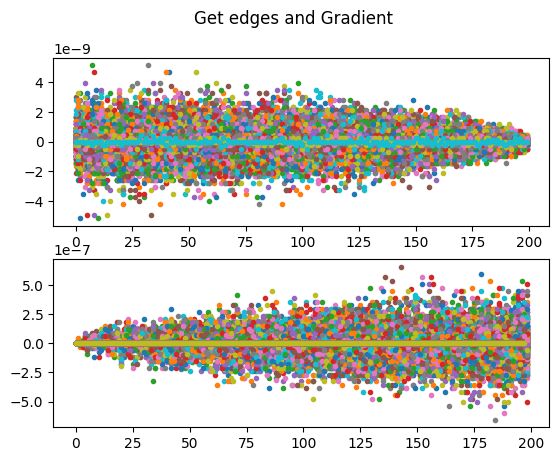

In [22]:
fig, axs = plt.subplots(2)
fig.suptitle('Get edges and Gradient')
axs[0].plot(E - E2,'.');
axs[1].plot(g - g2,'.');

number of texa ranging from 20 to 500, track the trend in error

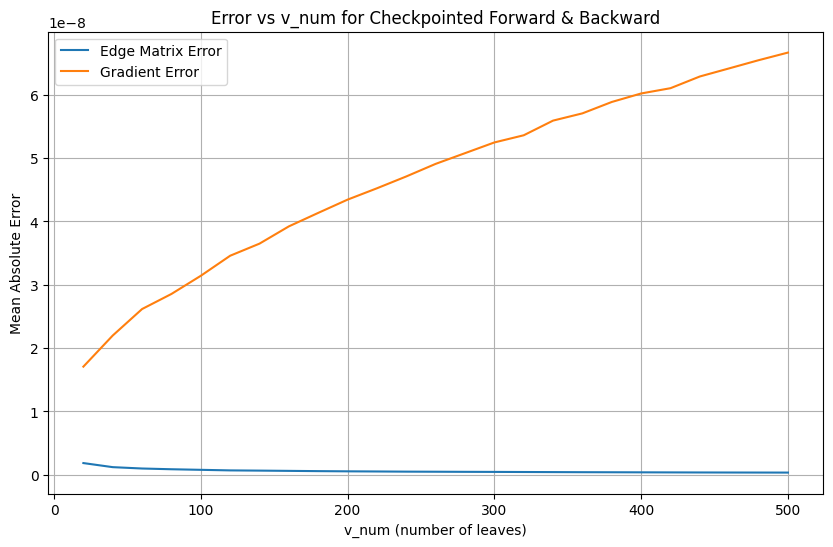

In [23]:
#v_num ranging from 20 to 500
v_list = list(range(20, 501, 20))
edge_errors = []
grad_errors = []

value_and_grad_fun = jax.jit(jax.value_and_grad(bme_loss, argnums=0))

for v_num in v_list:
    M = jnp.array(np.random.rand(round(0.5 * v_num * (v_num - 1))) * 0.5)
    D = jnp.array(np.random.rand(v_num, v_num) * (1 - np.eye(v_num)))
    D = 0.5 * (D + D.T)
    W = make_W(M)
    E2, cache = forward_sqrtn_checkpoint(np.array(W))
    g2 = backward_sqrtn_checkpoint(np.array(W), np.array(D), cache)
    E = get_edges_exp(W)
    v, g = value_and_grad_fun(W, D)
    edge_errors.append(np.mean(np.abs((E - E2))))
    grad_errors.append(np.mean(np.abs((g - g2))))


plt.figure(figsize=(10, 6))
plt.plot(v_list, edge_errors, label="Edge Matrix Error")
plt.plot(v_list, grad_errors, label="Gradient Error")
plt.xlabel("v_num (number of leaves)")
plt.ylabel("Mean Absolute Error")
plt.title("Error vs v_num for Checkpointed Forward & Backward")
plt.legend()
plt.grid(True)
plt.show()